In [13]:
import numpy as np

In [14]:
data = np.load("./data/language_phonemes_all.npz", allow_pickle=True)
language_phonemes_all = data["language_phonemes_all"]
language_names_all = data["language_names_all"]

assert language_phonemes_all.shape[0] == language_names_all.shape[0]
language_phonemes_all.shape, language_names_all.shape

((2949, 29, 24), (2949,))

In [15]:
unique_names, unique_names_count = np.unique(language_names_all, return_counts=True)
multiple_samples = unique_names[unique_names_count > 1]

count_sort_idx_desc = np.argsort(-unique_names_count)

most_common_languages = list(
    zip(unique_names[count_sort_idx_desc], unique_names_count[count_sort_idx_desc])
)

print(most_common_languages[0:5])

X = language_phonemes_all[np.in1d(language_names_all, multiple_samples)]
y = language_names_all[np.in1d(language_names_all, multiple_samples)]

sample_shape = X[0].shape
num_classes = len(unique_names)

y.shape, X.shape, sample_shape, num_classes

[('Iron Ossetic', 10), ('Dutch', 9), ('Basque', 6), ('Laz', 6), ('Northeastern Thai', 5)]


((342,), (342, 29, 24), (29, 24), 2740)

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [17]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.39, random_state=33)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

y_train.shape, y_test.shape

((208, 2740), (134, 2740))

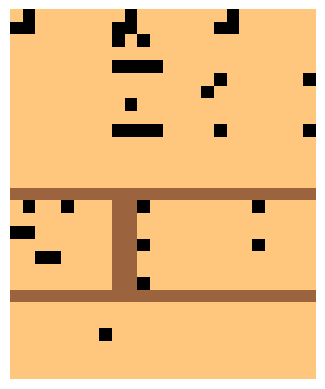

In [18]:
import matplotlib.pyplot as plt

plt.imshow(
    X[0],
    cmap=plt.get_cmap("copper_r"),
)
plt.axis("off")
plt.show()

In [19]:
from keras import Input, Sequential, layers

# Create network architecture

input_shape = X[0].shape

print(f"shape={input_shape}")

model = Sequential(
    [
        Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ],
    name="language_model"
)

model.summary()

shape=(29, 24)


Model: "language_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 696)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        89,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2740)           │       353,460 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 442,676 (1.69 MB)

 Trainable params: 442,676 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#Compilation

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

In [21]:
# Train

print(X_train.shape)
print(y_train.shape)



model.fit(X_train, y_train, epochs=10, batch_size=64)

(208, 29, 24)
(208, 2740)
Epoch 1/10


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0000e+00 - loss: 7.9222
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0030 - loss: 7.8213    
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0181 - loss: 7.6354 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0120 - loss: 7.3323    
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0393 - loss: 6.8312
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0258 - loss: 6.1446
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0113 - loss: 5.4407    
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0246 - loss: 4.9323
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0352 - loss: 4.7984 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0249 - loss: 4.7389


In [22]:
# accuracy doesn't look great, but it's not bad considering there
# is only one training sample of many of the languages and the
# number of classes is in the thousands

test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Classes: {num_classes}")
print(f"Samples per language: {num_classes / len(y_train):.2f}")
print(f"Random guess probability: {1 / num_classes:.5f}")
print(
    f"Most common language probability: {most_common_languages[0][1] / num_classes:.5f}"
)
print(
    f"5 most common language probability: {np.sum([y for _, y in most_common_languages[0:5]]) / num_classes:.5f}"
)
print(f"Model accuracy: {test_acc:.5f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0380 - loss: 5.1252  
Classes: 2740
Samples per language: 13.17
Random guess probability: 0.00036
Most common language probability: 0.00365
5 most common language probability: 0.01314
Model accuracy: 0.03731


In [23]:
# The predictions are heavily skewed towards languages that appear multiple
# times in the dataset (to be expected really). So, to genrate synthetic examples
# that don't just copy the most common languages, it'll probably be necessary to 
# limit the trainling data for synthetic data genertion to 1 example or a small 
# number of examples per language.

num_samples = 50
top_n_languages = set([name for name, _ in most_common_languages[0:5]])

predictions = label_encoder.inverse_transform(
    model.predict(X_test[0:num_samples]).argmax(axis=-1)
)
actual = label_encoder.inverse_transform(y_test[0:num_samples].argmax(axis=-1))

correct_predictions = sum([1 if p == a else 0 for p, a in zip(predictions, actual)])

predicted_from_common = sum([1 if p in top_n_languages else 0 for p in predictions])

print(f"Correct preditions: {correct_predictions / len(predictions) * 100}%")
print(f"Predicted from top 5: {predicted_from_common / len(predictions) * 100}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Correct preditions: 4.0%
Predicted from top 5: 100.0%
